# Daily Rain Reports


In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import matplotlib.pyplot as plt

import pandas as pd
import geopandas as gpd
import contextily as cx

from raindownloader.inpeparser import INPE, INPEParsers, INPETypes
from raindownloader.downloader import Downloader
from raindownloader.utils import FileType
from rainreporter.reporter import RainReporter

import rasterio as rio
import xarray as xr
from raindownloader.utils import GISUtil

## Opening Basins of Interest

In [2]:
shapes_mac = Path('/Users/cordmaur/Library/CloudStorage/OneDrive-AgênciaNacionaldeÁguas/Trabalho/SOE/COVEC/Bases/bacias de interesse SOE')
shapes_container = Path('/workspaces/bases/bacias de interesse SOE')

shapes = shapes_mac if shapes_mac.exists() else shapes_container
assert shapes.exists()

In [3]:
basins = {file.stem.split('_')[-1]: file for file in shapes.iterdir() if file.suffix == '.shp'}

In [4]:
basins

{'Doce': PosixPath('/workspaces/bases/bacias de interesse SOE/bacia_Doce.shp'),
 'wgs84': PosixPath('/workspaces/bases/bacias de interesse SOE/bacia_Doce_wgs84.shp'),
 'Itapecuru': PosixPath('/workspaces/bases/bacias de interesse SOE/bacia_Itapecuru.shp'),
 'Jequitinhonha': PosixPath('/workspaces/bases/bacias de interesse SOE/bacia_Jequitinhonha.shp'),
 'Madeira': PosixPath('/workspaces/bases/bacias de interesse SOE/bacia_Madeira.shp'),
 'PortoVelho': PosixPath('/workspaces/bases/bacias de interesse SOE/bacia_Madeira_em_PortoVelho.shp'),
 'Negro': PosixPath('/workspaces/bases/bacias de interesse SOE/bacia_Negro.shp'),
 'Paraguai': PosixPath('/workspaces/bases/bacias de interesse SOE/bacia_Paraguai.shp'),
 'ParaibaDoSul': PosixPath('/workspaces/bases/bacias de interesse SOE/bacias50k_ParaibaDoSul.shp'),
 'Parana': PosixPath('/workspaces/bases/bacias de interesse SOE/bacia_Parana.shp'),
 'Pardo': PosixPath('/workspaces/bases/bacias de interesse SOE/bacia_Pardo.shp'),
 'Parnaiba': PosixPa

## Creating the Reporter Object

In [6]:
reporter = RainReporter(
    server=INPEParsers.FTPurl, 
    download_folder='/workspaces/INPERainDownloader/tmp', 
    parsers=INPEParsers.parsers,
    post_processors=INPEParsers.post_processors
)


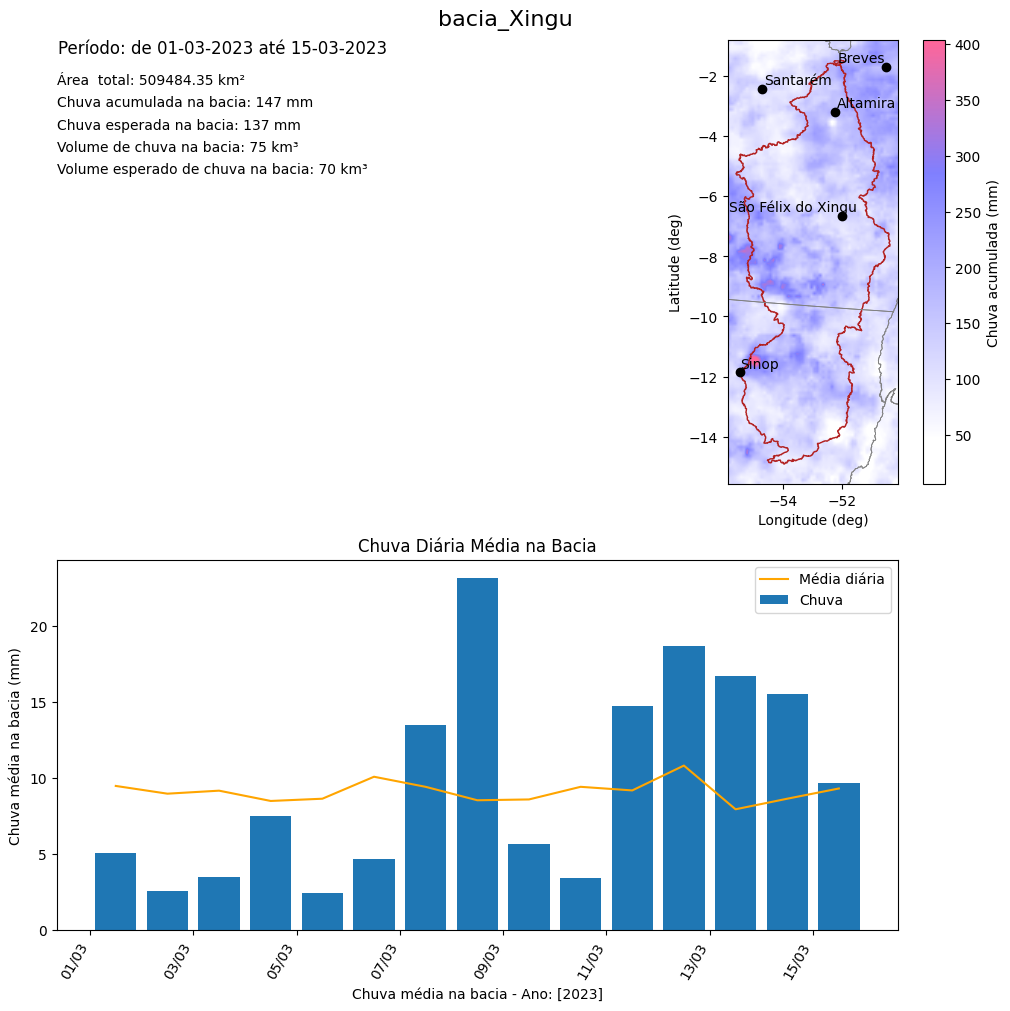

In [6]:
ax, rain, shp, cube = reporter.daily_rain_report(
    start_date='20230301',
    end_date='20230315',
    shapefile=basins['Xingu']
)

## Anomalies

In [68]:
parser = reporter.downloader.get_parser(INPETypes.DAILY_RAIN)

In [75]:
files = parser.get_range(
    start_date='20230401',
    end_date='20230418',
    local_folder='/workspaces/INPERainDownloader/tmp',
    force_download=True
)

In [76]:
files

[PosixPath('/workspaces/INPERainDownloader/tmp/DAILY_RAIN/MERGE_CPTEC_20230401.grib2'),
 PosixPath('/workspaces/INPERainDownloader/tmp/DAILY_RAIN/MERGE_CPTEC_20230402.grib2'),
 PosixPath('/workspaces/INPERainDownloader/tmp/DAILY_RAIN/MERGE_CPTEC_20230403.grib2'),
 PosixPath('/workspaces/INPERainDownloader/tmp/DAILY_RAIN/MERGE_CPTEC_20230404.grib2'),
 PosixPath('/workspaces/INPERainDownloader/tmp/DAILY_RAIN/MERGE_CPTEC_20230405.grib2'),
 PosixPath('/workspaces/INPERainDownloader/tmp/DAILY_RAIN/MERGE_CPTEC_20230406.grib2'),
 PosixPath('/workspaces/INPERainDownloader/tmp/DAILY_RAIN/MERGE_CPTEC_20230407.grib2'),
 PosixPath('/workspaces/INPERainDownloader/tmp/DAILY_RAIN/MERGE_CPTEC_20230408.grib2'),
 PosixPath('/workspaces/INPERainDownloader/tmp/DAILY_RAIN/MERGE_CPTEC_20230409.grib2'),
 PosixPath('/workspaces/INPERainDownloader/tmp/DAILY_RAIN/MERGE_CPTEC_20230410.grib2'),
 PosixPath('/workspaces/INPERainDownloader/tmp/DAILY_RAIN/MERGE_CPTEC_20230411.grib2'),
 PosixPath('/workspaces/INPERain

In [81]:
from raindownloader.utils import GISUtil
import xarray as xr

In [87]:
xr.open_dataset('../MERGE_CPTEC_20230407.grib2')

<xarray.Dataset>
Dimensions:     (latitude: 924, longitude: 1001)
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 -60.05 -59.95 -59.85 ... 32.05 32.15 32.25
  * longitude   (longitude) float64 239.9 240.0 240.1 ... 339.8 339.9 340.0
    valid_time  datetime64[ns] ...
Data variables:
    prec        (latitude, longitude) float32 ...
    prmsl       (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             consensus
    GRIB_centreDescription:  Consensus
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Consensus
    history:                 2023-04-18T17:23 GRIB to CDM+CF via cfgrib-0.9.1...

In [89]:
xr.open_dataset(files[7])

<xarray.Dataset>
Dimensions:     (latitude: 924, longitude: 1001)
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 -60.05 -59.95 -59.85 ... 32.05 32.15 32.25
  * longitude   (longitude) float64 239.9 240.0 240.1 ... 339.8 339.9 340.0
    valid_time  datetime64[ns] ...
Data variables:
    prec        (latitude, longitude) float32 ...
    prmsl       (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             consensus
    GRIB_centreDescription:  Consensus
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Consensus
    history:                 2023-04-18T17:24 GRIB to CDM+CF via cfgrib-0.9.1...

In [90]:
cube = GISUtil.create_cube(
    files=files[:-1],
    dim_key='time'
)

In [94]:
cube = INPE.grib2_post_proc(cube)

In [97]:
accum = cube[INPETypes.DAILY_RAIN.value['var']].sum(dim="time")


In [101]:
axs, rain, lta, shp = reporter.monthly_anomaly_report(
    date_str='2023-04',
    shapefile=basins['Doce'],
)

: 

: 

In [1]:
cube

NameError: name 'cube' is not defined